# Docking

This tutorial showcases how to use ProLIF to generate an interaction fingerprint for interactions between a protein and different docking poses.

ProLIF currently provides file readers for docking poses for MOL2, SDF and PDBQT files which rely on RDKit or MDAnalysis (or both).

:::{important}
For convenience, the different files for this tutorial are included with the ProLIF installation, and we'll access these files through `plf.datafiles.datapath` which is a {class}`pathlib.Path` object pointing to the tutorials data directory. This makes it easier to manipulate paths to files, match filenames using wildcards...etc. in a Pythonic way, but you can also use plain strings, e.g. `"/home/user/prolif/data/vina/rec.pdb"` instead of `plf.datafiles.datapath / "vina" / "rec.pdb"` if you prefer.

**Remember to replace any reference to `plf.datafiles.datapath` with the actual paths to your inputs outside of this tutorial.**
:::

:::{tip}
At the top of the page you can find links to either download this notebook or run it in
Google Colab. You can install the dependencies for the tutorials with the command:

```shell
pip install prolif[tutorials]
```
:::

In [1]:
!pip install prolif[tutorials]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.4 MB/s eta 0:00:00


## Protein preparation

Let's start by importing MDAnalysis and ProLIF to read our protein for this tutorial.

In this tutorial we'll be using a PDB file but you can also use the MOL2 format as shown later on.

:::{important}
No matter which file format you chose to use for the protein, it **must contain explicit hydrogens**.
:::

### PDB file

We have 2 options to read the protein file: MDAnalysis (preferred) or RDKit (faster but risky, see below).

:::{important}
While RDKit is going to be much faster at parsing the file, it can only recognize standard residue names, so some protonated residues may be incorrectly parsed.

For example, the protonated histidine residue HSE347 in our protein is not correcltly parsed which removes aromaticity on the ring, meaning that ProLIF will not be able to match this residue for pi-stacking interactions.
:::

/usr/local/lib/python3.11/dist-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)


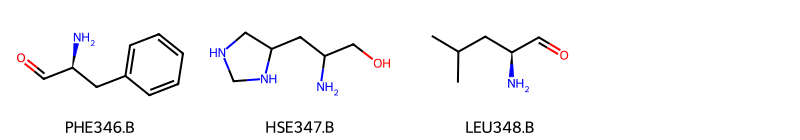

In [2]:
import prolif as plf
from rdkit import Chem

protein_file = str(plf.datafiles.datapath / "vina" / "rec.pdb")

rdkit_prot = Chem.MolFromPDBFile(protein_file, removeHs=False)
protein_mol = plf.Molecule(rdkit_prot)
# histidine HSE347 not recognized by RDKit
plf.display_residues(protein_mol, slice(260, 263))

Unless you know for sure that all the residue names in your PDB file are standard, it is thus recommanded that you use MDAnalysis for parsing the protein.

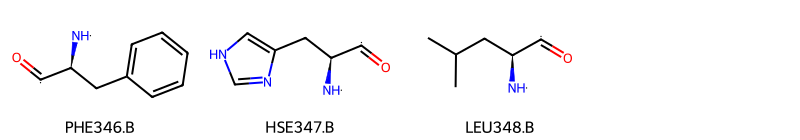

In [3]:
import MDAnalysis as mda
import prolif as plf

u = mda.Universe(protein_file)
protein_mol = plf.Molecule.from_mda(u)
# display (remove `slice(260, 263)` to show all residues)
plf.display_residues(protein_mol, slice(260, 263))

:::{important}
Make sure that your PDB file either has all bonds explicitely stated, or none of them.
:::

:::{admonition} Troubleshooting

In some cases, some atomic clashes may be incorrectly classified as bonds and will prevent the conversion of the MDAnalysis molecule to RDKit through ProLIF. Since MDAnalysis uses van der Waals radii for bond detection, one can modify the default radii that are used:

```python
u.atoms.guess_bonds(vdwradii={"H": 1.05, "O": 1.48})
```

:::

### MOL2 file

You could also use a MOL2 file for the protein, here's a code snippet to guide you:

```python
u = mda.Universe("protein.mol2")
# add "elements" category
elements = mda.topology.guessers.guess_types(u.atoms.names)
u.add_TopologyAttr("elements", elements)
# create protein mol
protein_mol = plf.Molecule.from_mda(u)
```

:::{admonition} Troubleshooting

While doing so, you may run into one of these errors:
- **`RDKit ERROR: Can't kekulize mol. Unkekulized atoms`**
- **`RDKit ERROR: non-ring atom marked aromatic`**

This usually happens when some of the bonds in the MOL2 file are unconventional. For example in MOE, charged histidines are represented part with aromatic bonds and part with single and double bonds, presumably to capture the different charged resonance structures in a single one. A practical workaround for this is to redefine problematic bonds as single bonds in the `Universe` object:

```python
u = mda.Universe("protein.mol2")
# replace aromatic bonds with single bonds
for i, bond_order in enumerate(u._topology.bonds.order):
    # you may need to replace double bonds ("2") as well
    if bond_order == "ar":
        u._topology.bonds.order[i] = 1
# clear the bond cache, just in case
u._topology.bonds._cache.pop("bd", None)
# infer bond orders again
protein_mol = plf.Molecule.from_mda(u)
```
:::

The parsing of residue info in MOL2 files can sometimes fail and lead to the residue index being appended to the residue name and number. You can fix this with the following snippet:

```python
import numpy as np

u = mda.Universe("protein.mol2")
resids = [
    plf.ResidueId.from_string(x) for x in u.residues.resnames
]
u.residues.resnames = np.array([x.name for x in resids], dtype=object)
u.residues.resids = np.array([x.number for x in resids], dtype=np.uint32)
u.residues.resnums = u.residues.resids
protein_mol = plf.Molecule.from_mda(u)
```

## Docking poses preparation

Loading docking poses is done through one of the `supplier` functions available in ProLIF. These will read your input file with either RDKit or MDAnalysis and handle any additional preparation.

### SDF format

The SDF format is the easiest way for ProLIF to parse docking poses:

In [4]:
# load ligands
poses_path = str(plf.datafiles.datapath / "vina" / "vina_output.sdf")
pose_iterable = plf.sdf_supplier(poses_path)

### MOL2 format

MOL2 is another format that should be easy for ProLIF to parse:

In [5]:
# load ligands
poses_path = str(plf.datafiles.datapath / "vina" / "vina_output.mol2")
pose_iterable = plf.mol2_supplier(poses_path)

### PDBQT format

The typical use case here is getting the IFP from AutoDock Vina's output. It requires a few additional steps and informations compared to other formats like MOL2, since the PDBQT format gets rid of most hydrogen atoms and doesn't contain bond order information, which are both needed for ProLIF to work.

:::{important}
Consider using [Meeko](https://github.com/forlilab/Meeko) to prepare your inputs for Vina as it contains some utilities to [convert the output poses](https://github.com/forlilab/Meeko#examples-using-the-command-line-scripts) to the SDF format which is a lot safer than the solution proposed here.
:::

:::{tip}
Do not use OpenBabel to convert your PDBQT poses to SDF, it will not be able to guess the bond orders and charges correctly.
:::

The prerequisites for a successfull usage of ProLIF in this case is having external files that contain bond orders and formal charges for your ligand (like SMILES, SDF or MOL2).

:::{note}
Please note that your PDBQT input must have a single model per file (this is required by `MDAnalysis`). Splitting a multi-model file can be done using the `vina_split` command-line tool that comes with AutoDock Vina: `vina_split --input vina_output.pdbqt`
:::

Let's start by loading our "template" file with bond orders. It can be a SMILES string, MOL2, SDF file or anything supported by RDKit.

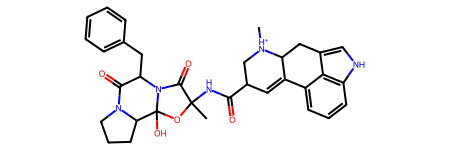

In [6]:
from rdkit import Chem

template = Chem.MolFromSmiles(
    "C[NH+]1CC(C(=O)NC2(C)OC3(O)C4CCCN4C(=O)C(Cc4ccccc4)N3C2=O)C=C2c3cccc4[nH]cc(c34)CC21"
)
template

Next, we'll use the PDBQT supplier which loads each file from a list of paths, and assigns bond orders and charges using the template.

In [7]:
# load list of ligands
pdbqt_files = sorted(plf.datafiles.datapath.glob("vina/*.pdbqt"))
pdbqt_files

[PosixPath('/usr/local/lib/python3.11/dist-packages/prolif/data/vina/vina_output_ligand_1.pdbqt'),
 PosixPath('/usr/local/lib/python3.11/dist-packages/prolif/data/vina/vina_output_ligand_2.pdbqt'),
 PosixPath('/usr/local/lib/python3.11/dist-packages/prolif/data/vina/vina_output_ligand_3.pdbqt'),
 PosixPath('/usr/local/lib/python3.11/dist-packages/prolif/data/vina/vina_output_ligand_4.pdbqt'),
 PosixPath('/usr/local/lib/python3.11/dist-packages/prolif/data/vina/vina_output_ligand_5.pdbqt'),
 PosixPath('/usr/local/lib/python3.11/dist-packages/prolif/data/vina/vina_output_ligand_6.pdbqt'),
 PosixPath('/usr/local/lib/python3.11/dist-packages/prolif/data/vina/vina_output_ligand_7.pdbqt'),
 PosixPath('/usr/local/lib/python3.11/dist-packages/prolif/data/vina/vina_output_ligand_8.pdbqt'),
 PosixPath('/usr/local/lib/python3.11/dist-packages/prolif/data/vina/vina_output_ligand_9.pdbqt')]

In [8]:
pose_iterable = plf.pdbqt_supplier(pdbqt_files, template)

## Fingerprint generation

We can now generate a fingerprint. By default, ProLIF will calculate the following interactions: Hydrophobic, HBDonor, HBAcceptor, PiStacking, Anionic, Cationic, CationPi, PiCation, VdWContact.
You can list all interactions that are available with the following command:

In [9]:
plf.Fingerprint.list_available()

['Anionic',
 'CationPi',
 'Cationic',
 'EdgeToFace',
 'FaceToFace',
 'HBAcceptor',
 'HBDonor',
 'Hydrophobic',
 'MetalAcceptor',
 'MetalDonor',
 'PiCation',
 'PiStacking',
 'VdWContact',
 'XBAcceptor',
 'XBDonor']

:::{tip}
The default fingerprint will only keep track of the first group of atoms that satisfied the constraints per interaction type and residue pair.

If you want to keep track of all possible interactions to generate a count-fingerprint (e.g. when there are two atoms in the ligand that make an HBond-donor interaction with residue X), use `plf.Fingerprint(count=True)`.
This is also quite useful for visualization purposes as you can then display the atom pair that has the shortest distance which will look more accurate.
This fingerprint type is however a bit slower to compute.
:::

In [10]:
# use default interactions
fp = plf.Fingerprint()
# run on your poses
fp.run_from_iterable(pose_iterable, protein_mol)

  0%|          | 0/9 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x7ab2cd15cf90>

:::{tip}
The `run_from_iterable` method will automatically select residues that are close to the ligand (6.0 Å) when computing the fingerprint. You can modify the 6.0 Å cutoff by specifying `plf.Fingerprint(vicinity_cutoff=7.0)`, but this is only useful if you decide to change the distance parameters for an interaction class (see in the advanced section of the tutorials).

Alternatively, you can pass a list of residues like so:

```python
fp.run_from_iterable(<other parameters>, residues=["TYR38.A", "ASP129.A"])
```
:::

You can save the fingerprint object with `fp.to_pickle` and reload it later with `Fingerprint.from_pickle`:

In [11]:
fp.to_pickle("fingerprint.pkl")
fp = plf.Fingerprint.from_pickle("fingerprint.pkl")

## Analysis

Once the execution is done, you can access the results through `fp.ifp` which is a nested dictionary:

In [12]:
pose_index = 0
ligand_residue = "LIG1.G"
protein_residue = "ASP129.A"

fp.ifp[pose_index][(ligand_residue, protein_residue)]

{'HBDonor': ({'indices': {'ligand': (20, 44), 'protein': (8,)},
   'parent_indices': {'ligand': (20, 44), 'protein': (1489,)},
   'distance': 3.0217454547036415,
   'DHA_angle': 148.56916365119588},),
 'Cationic': ({'indices': {'ligand': (20,), 'protein': (8,)},
   'parent_indices': {'ligand': (20,), 'protein': (1489,)},
   'distance': 3.0217454547036415},),
 'VdWContact': ({'indices': {'ligand': (20,), 'protein': (8,)},
   'parent_indices': {'ligand': (20,), 'protein': (1489,)},
   'distance': 3.0217454547036415},)}

While this contains all the details about the different interactions that were detected, it's not the easiest thing to digest.

The best way to analyse our results is to export the interaction fingerprint to a Pandas DataFrame. You can read more about pandas in their
[user_guide](https://pandas.pydata.org/docs/user_guide/index.html).

In [13]:
df = fp.to_dataframe(index_col="Pose")
# show only the 5 first poses
df.head(5)

ligand           LIG1.G                                               \
protein         TYR38.A                          TYR109.A              
interaction Hydrophobic HBAcceptor VdWContact Hydrophobic PiStacking   
Pose                                                                   
0                 False      False      False       False      False   
1                 False      False      False       False      False   
2                 False      False      False       False      False   
3                  True      False       True       False      False   
4                  True       True       True       False      False   

ligand                                                                ...  \
protein                   TRP125.A               LEU126.A             ...   
interaction VdWContact Hydrophobic VdWContact Hydrophobic VdWContact  ...   
Pose                                                                  ...   
0                False       False      False       False      False  ...   
1                False       False      False        True       True  ...   
2                False       False      False        True       True  ...   
3                False       False      False       False      False  ...   
4                False       False      False       False      False  ...   

ligand                                                                 \
protein       PRO338.B    PHE346.B    LEU348.B               PHE351.B   
interaction VdWContact Hydrophobic Hydrophobic VdWContact Hydrophobic   
Pose                                                                    
0                False       False       False      False        True   
1                False       False       False      False        True   
2                False       False       False      False       False   
3                False       False       False      False        True   
4                 True        True        True       True        True   

ligand                                                                
protein                  ASP352.B    THR355.B               TYR359.B  
interaction VdWContact VdWContact Hydrophobic VdWContact Hydrophobic  
Pose                                                                  
0                 True      False       False      False       False  
1                False       True       False       True       False  
2                False       True       False       True       False  
3                 True      False       False       True       False  
4                 True      False       False      False       False  

[5 rows x 54 columns]

:::{admonition} Troubleshooting
If the dataframe only shows VdWContact interactions and nothing else, you may have a skipped the
protein preparation step for protein PDB file: **either all bonds should be explicit, or none of them.**

If you only have partial bonds in your PDB file, MDAnalysis won't trigger the bond guessing algorithm so
your protein is essentially a point cloud that can't match with any of the atom selections
specified by interactions other than VdW.

To fix this, simply add the following line after creating a `Universe` from your protein file
with MDAnalysis:

```python
u.atoms.guess_bonds()
```
and rerun the rest of the notebook.

:::

Here are some common pandas snippets to extract useful information from the fingerprint table.

:::{important}
Make sure to remove the `.head(5)` at the end of the commands to display the results for all the frames.
:::

In [14]:
# hide an interaction type (Hydrophobic)
df.drop("Hydrophobic", level="interaction", axis=1).head(5)

ligand          LIG1.G                                                         \
protein        TYR38.A              TYR109.A              TRP125.A   LEU126.A   
interaction HBAcceptor VdWContact PiStacking VdWContact VdWContact VdWContact   
Pose                                                                            
0                False      False      False      False      False      False   
1                False      False      False      False      False       True   
2                False      False      False      False      False       True   
3                False       True      False      False      False      False   
4                 True       True      False      False      False      False   

ligand                                               ...             \
protein     ASP129.A                       ILE130.A  ...   PHE330.B   
interaction  HBDonor Cationic VdWContact VdWContact  ... PiStacking   
Pose                                                 ...              
0               True     True       True      False  ...      False   
1              False    False      False       True  ...      False   
2              False    False      False       True  ...      False   
3               True    False       True       True  ...      False   
4              False    False      False      False  ...       True   

ligand                                                                         \
protein                  PHE331.B   SER334.B   MET337.B   PRO338.B   LEU348.B   
interaction VdWContact VdWContact VdWContact VdWContact VdWContact VdWContact   
Pose                                                                            
0                 True       True      False       True      False      False   
1                 True      False       True       True      False      False   
2                 True      False       True      False      False      False   
3                 True      False      False      False      False      False   
4                 True      False       True      False       True       True   

ligand                                        
protein       PHE351.B   ASP352.B   THR355.B  
interaction VdWContact VdWContact VdWContact  
Pose                                          
0                 True      False      False  
1                False       True       True  
2                False       True       True  
3                 True      False       True  
4                 True      False      False  

[5 rows x 33 columns]

In [15]:
# show only one protein residue (ASP129.A)
df.xs("ASP129.A", level="protein", axis=1).head(5)

ligand       LIG1.G                    
interaction HBDonor Cationic VdWContact
Pose                                   
0              True     True       True
1             False    False      False
2             False    False      False
3              True    False       True
4             False    False      False

In [16]:
# show only an interaction type (PiStacking)
df.xs("PiStacking", level="interaction", axis=1).head(5)

ligand    LIG1.G         
protein TYR109.A PHE330.B
Pose                     
0          False    False
1          False    False
2          False    False
3          False    False
4          False     True

In [17]:
# percentage of poses where each interaction is present
(df.mean().sort_values(ascending=False).to_frame(name="%").T * 100)

ligand          LIG1.G                                                 \
protein       VAL201.A                MET337.B   PHE330.B               
interaction VdWContact Hydrophobic Hydrophobic VdWContact Hydrophobic   
%                100.0   88.888889   77.777778  77.777778   77.777778   

ligand                                                                 ...  \
protein        PHE351.B    THR203.A    VAL200.A   PHE351.B   VAL201.A  ...   
interaction Hydrophobic Hydrophobic Hydrophobic VdWContact HBAcceptor  ...   
%             66.666667   55.555556   55.555556  55.555556  55.555556  ...   

ligand                                                               \
protein        TRP125.A   PHE330.B   GLN189.A    TYR38.A   ASN202.A   
interaction Hydrophobic PiStacking VdWContact HBAcceptor VdWContact   
%             11.111111  11.111111  11.111111  11.111111  11.111111   

ligand                                                                 
protein                   PRO184.A               VAL196.A    TYR359.B  
interaction HBAcceptor Hydrophobic VdWContact Hydrophobic Hydrophobic  
%            11.111111   11.111111  11.111111   11.111111   11.111111  

[1 rows x 54 columns]

In [18]:
# same but we regroup all interaction types
(
    df.T.groupby(level=["ligand", "protein"])
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

ligand    LIG1.G                                                       \
protein VAL201.A PHE330.B   MET337.B   VAL200.A   PHE351.B   THR203.A   
%          100.0    100.0  77.777778  66.666667  66.666667  55.555556   

ligand                                               ...             \
protein   ILE130.A   SER334.B   THR355.B   THR209.A  ...   PRO184.A   
%        44.444444  44.444444  44.444444  44.444444  ...  22.222222   

ligand                                                                     \
protein   TRP125.A   TYR109.A   VAL196.A   TYR359.B   ARG188.A   ASN202.A   
%        22.222222  22.222222  11.111111  11.111111  11.111111  11.111111   

ligand                                    
protein   PHE346.B   GLN189.A   PRO338.B  
%        11.111111  11.111111  11.111111  

[1 rows x 29 columns]

In [19]:
# percentage of poses where PiStacking interactions are present, by residue
(
    df.xs("PiStacking", level="interaction", axis=1)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

ligand      LIG1.G           
protein   TYR109.A   PHE330.B
%        11.111111  11.111111

In [20]:
# percentage of poses where interactions with PHE330 occur, by interaction type
(
    df.xs("PHE330.B", level="protein", axis=1)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

ligand           LIG1.G                      
interaction Hydrophobic VdWContact PiStacking
%             77.777778  77.777778  11.111111

In [21]:
# percentage of poses where each interaction type is present
(
    df.T.groupby(level="interaction")
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="%")
    .T
    * 100
)

interaction,Hydrophobic,VdWContact,HBAcceptor,HBDonor,Cationic,PiStacking
%,100.0,100.0,77.777778,55.555556,33.333333,22.222222


In [22]:
# 10 residues most frequently interacting with the ligand
(
    df.T.groupby(level=["ligand", "protein"])
    .sum()
    .T.astype(bool)
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .to_frame("%")
    .T
    * 100
)

ligand    LIG1.G                                                       \
protein VAL201.A PHE330.B   MET337.B   VAL200.A   PHE351.B   THR203.A   
%          100.0    100.0  77.777778  66.666667  66.666667  55.555556   

ligand                                               
protein   ILE130.A   SER334.B   THR355.B   THR209.A  
%        44.444444  44.444444  44.444444  44.444444

You can compute a Tanimoto similarity between poses:

In [23]:
# Tanimoto similarity between the first frame and the rest
from rdkit import DataStructs

bitvectors = fp.to_bitvectors()
tanimoto_sims = DataStructs.BulkTanimotoSimilarity(bitvectors[0], bitvectors)
tanimoto_sims

[1.0,
 0.28125,
 0.21875,
 0.25925925925925924,
 0.2413793103448276,
 0.7272727272727273,
 0.1935483870967742,
 0.35714285714285715,
 0.3225806451612903]

### Comparing docking poses with a reference ligand

If you have a reference ligand that you wish to use for comparison with your docking poses, you can do so the following way:

:::{important}
Just like for the protein, you reference ligand must contain explicit hydrogens. If the reference comes from a PDB file, you could use PyMOL to add hydrogens to it and export the prepared reference.
:::

In [24]:
# load the reference
ref = mda.Universe(plf.datafiles.datapath / "vina" / "lig.pdb")
ref_mol = plf.Molecule.from_mda(ref)

# generate IFP for the reference
fp_ref = plf.Fingerprint(fp.interactions)
fp_ref.run_from_iterable([ref_mol], protein_mol)
df_ref = fp_ref.to_dataframe(index_col="Pose")

# set the "pose index" to -1
df_ref.rename(index={0: -1}, inplace=True)
# set the ligand name to be the same as poses
df_ref.rename(columns={str(ref_mol[0].resid): df.columns.levels[0][0]}, inplace=True)
df_ref

  0%|          | 0/1 [00:00<?, ?it/s]

ligand           LIG1.G                                                       \
protein        TYR109.A    TRP125.A    LEU126.A ASP129.A                       
interaction Hydrophobic Hydrophobic Hydrophobic  HBDonor Cationic VdWContact   
Pose                                                                           
-1                 True        True        True     True     True       True   

ligand                                                      ...              \
protein        ILE130.A    CYS133.A   VAL200.A    VAL201.A  ...    ALA216.A   
interaction Hydrophobic Hydrophobic VdWContact Hydrophobic  ... Hydrophobic   
Pose                                                        ...               
-1                 True        True       True        True  ...        True   

ligand                                                                \
protein                   PHE330.B               PHE331.B              
interaction VdWContact Hydrophobic VdWContact Hydrophobic PiStacking   
Pose                                                                   
-1                True        True       True        True       True   

ligand                                                     
protein                   MET337.B    PHE351.B   ASP352.B  
interaction VdWContact Hydrophobic Hydrophobic VdWContact  
Pose                                                       
-1                True        True        True       True  

[1 rows x 28 columns]

In [25]:
# concatenate both dataframes
import pandas as pd

df_ref_poses = (
    pd.concat([df_ref, df])
    .fillna(False)
    .sort_index(
        axis=1,
        level=1,
        key=lambda index: [plf.ResidueId.from_string(x) for x in index],
    )
)
df_ref_poses

<ipython-input-25-d3c2dac9dbcd>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)


ligand          LIG1.G                                                \
protein        TYR38.A                           TYR109.A              
interaction HBAcceptor Hydrophobic VdWContact Hydrophobic PiStacking   
Pose                                                                   
-1               False       False      False        True      False   
 0               False       False      False       False      False   
 1               False       False      False       False      False   
 2               False       False      False       False      False   
 3               False        True       True       False      False   
 4                True        True       True       False      False   
 5               False       False      False       False      False   
 6               False        True       True        True       True   
 7               False        True       True       False      False   
 8               False       False      False       False      False   

ligand                                                                ...  \
protein                   TRP125.A               LEU126.A             ...   
interaction VdWContact Hydrophobic VdWContact Hydrophobic VdWContact  ...   
Pose                                                                  ...   
-1               False        True      False        True      False  ...   
 0               False       False      False       False      False  ...   
 1               False       False      False        True       True  ...   
 2               False       False      False        True       True  ...   
 3               False       False      False       False      False  ...   
 4               False       False      False       False      False  ...   
 5               False       False      False       False      False  ...   
 6                True        True       True       False      False  ...   
 7                True       False       True       False      False  ...   
 8               False       False      False        True       True  ...   

ligand                                                                 \
protein       PRO338.B    PHE346.B    LEU348.B               PHE351.B   
interaction VdWContact Hydrophobic Hydrophobic VdWContact Hydrophobic   
Pose                                                                    
-1               False       False       False      False        True   
 0               False       False       False      False        True   
 1               False       False       False      False        True   
 2               False       False       False      False       False   
 3               False       False       False      False        True   
 4                True        True        True       True        True   
 5               False       False       False      False       False   
 6               False       False        True       True        True   
 7               False       False        True       True        True   
 8               False       False       False      False       False   

ligand                                                                
protein                  ASP352.B    THR355.B               TYR359.B  
interaction VdWContact VdWContact Hydrophobic VdWContact Hydrophobic  
Pose                                                                  
-1               False       True       False      False       False  
 0                True      False       False      False       False  
 1               False       True       False       True       False  
 2               False       True       False       True       False  
 3                True      False       False       True       False  
 4                True      False       False      False       False  
 5               False       True       False      False       False  
 6                True      False        True       True        True  
 7                True      False    

We can now calculate the Tanimoto similarity between our reference ligand and the docking poses:

In [26]:
bitvectors = plf.to_bitvectors(df_ref_poses)
tanimoto_sims = DataStructs.BulkTanimotoSimilarity(bitvectors[0], bitvectors[1:])
tanimoto_sims

[0.5161290322580645,
 0.3157894736842105,
 0.3333333333333333,
 0.22857142857142856,
 0.18421052631578946,
 0.5666666666666667,
 0.15,
 0.23684210526315788,
 0.3157894736842105]

## Visualisation

There are a few different options builtin when it comes to visualisation.

You can start by plotting the interactions over time:

<Axes: xlabel='Pose'>

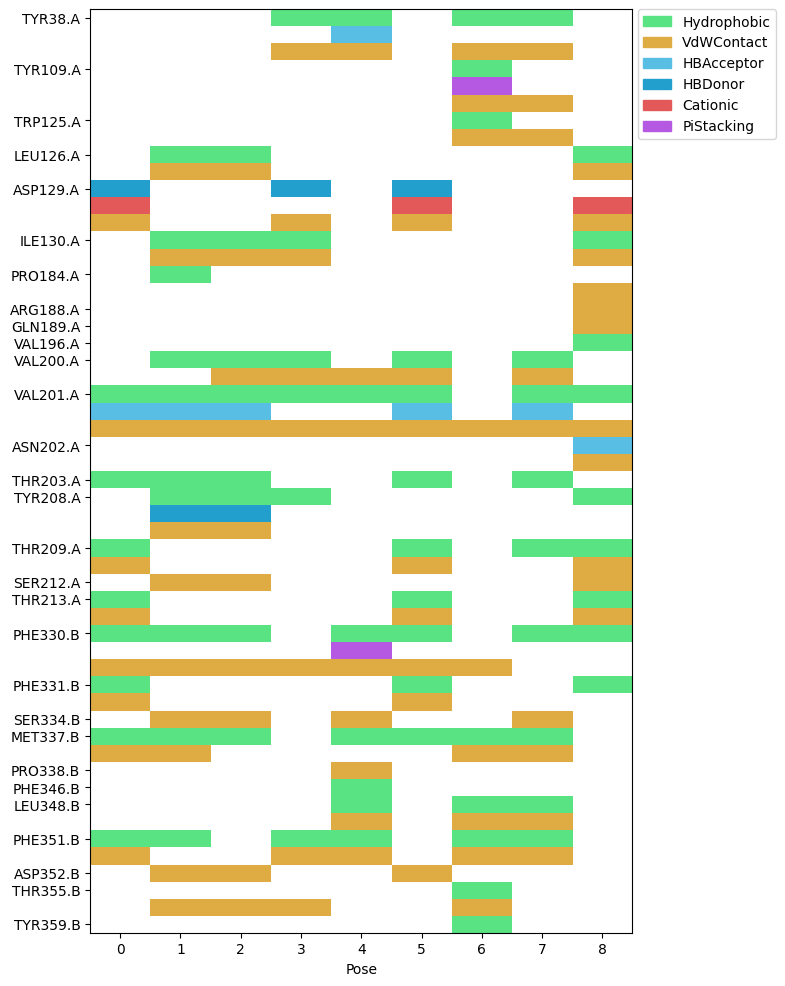

In [27]:
# %matplotlib ipympl

fp.plot_barcode(xlabel="Pose")

:::{tip}
If you uncomment `%matplotlib ipympl` at the top of the above cell, you should be able to see an interactive version of the plot.
:::

You can also display the interactions in a 2D interactive diagram:

In [28]:
view = fp.plot_lignetwork(pose_iterable[0])
view

This diagram is interactive, you can:
- zoom and pan,
- move residues around,
- click on the legend to display or hide types of residues or interactions,
- hover an interaction line to display the distance.

:::{note}
After arranging the residues to your liking, you can save the plot as a PNG image with:
```python
view.save_png()
```
Note that this only works in notebooks and cannot be used in regular Python scripts.
:::

You can generate 2 types of diagram with this function, controlled by the `kind` argument:
- `frame`: shows a single specific docking pose (specified with `frame`, corresponds to the `Pose` index in the dataframe).
- `aggregate` (default): the interactions from all poses are grouped and displayed. An optional `threshold` parameter controls the minimum frequency required for an interaction to be displayed (default `0.3`, meaning that interactions occuring in less than 30% of poses will be hidden). The width of interactions is linked to the frequency.

Showing a specific pose:

In [29]:
pose_index = 0
view = fp.plot_lignetwork(pose_iterable[pose_index], kind="frame", frame=pose_index)
view

Up to now we've only been using the default fingerprint generator, but you can optionally enable the `count` parameter to enumerate all occurences of an interaction (the default fingerprint generator will stop at the first occurence), and then display all of them by specifying `display_all=True`:

In [30]:
fp_count = plf.Fingerprint(count=True)
fp_count.run_from_iterable(pose_iterable, protein_mol)
view = fp_count.plot_lignetwork(
    pose_iterable[pose_index], kind="frame", frame=pose_index, display_all=True
)
view

  0%|          | 0/9 [00:00<?, ?it/s]

You can also visualize this information in 3D:

In [31]:
view = fp_count.plot_3d(
    pose_iterable[pose_index], protein_mol, frame=pose_index, display_all=False
)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

As in the lignetwork plot, you can hover atoms and interactions to display more information.

The advantage of using a count fingerprint in that case is that it will automatically select the interaction occurence with the shortest distance for a more intuitive visualization.

Once you're satisfied with the orientation, you can export the view as a PNG image with:

```python
view.save_png()
```
Note that this only works in notebooks and cannot be used in regular Python scripts.
```

You can also compare two different poses on the same view, and the protein residues that have
different interactions in the other pose or are missing will be highlighted in magenta:

In [32]:
from prolif.plotting.complex3d import Complex3D

pose_index = 0
comp3D = Complex3D.from_fingerprint(
    fp, pose_iterable[pose_index], protein_mol, frame=pose_index
)

pose_index = 4
other_comp3D = Complex3D.from_fingerprint(
    fp, pose_iterable[pose_index], protein_mol, frame=pose_index
)

view = comp3D.compare(other_comp3D)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

You could also superimpose them:

In [33]:
view = comp3D.display()
# other_comp3D will be displayed in green
other_comp3D.LIGAND_STYLE["stick"]["colorscheme"] = "greenCarbon"
other_comp3D._populate_view(view)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.